# Filmaffinity scrapper

## Description

My intention is to create a scrapper from all the way up of Filmaffinity. To gather the data I'll need to make my own scrapper. Mainly, the information I want to get is the following:

From films and series:

* Title
* Year
* Running time
* Country
* Director(s)
* Screenwriter(s)
* Cast
* Cinematography
* Producer(s)
* Genre(s)
* Synopsis
* Rating
* Pro rating
* Streaming services available

From actors:

* Name
* Date of birth
* Filmography
* Awards (wins and nominations)

From reviews:

* Film
* Author number of reviews
* Author number of ratings
* Users agree with review
* Total rating average
* Date of review


## Constants

In [2]:
BASE_URL = "https://www.filmaffinity.com/es"

## Imports

In [18]:
import requests
import selenium
from bs4 import BeautifulSoup
import re

## Manual test

First of all, what I need to do is to browse the Filmaffinity webpage in order to find from where I need to start scrapping the data.

I think the starting point should be the section "Top FA" where you can search applying different filters.

I realise that you can only select 10 different platforms to look up for films and series. However, in my opinion, this are where the vast majority of content is posted in. I've never hear 90% of names on this list.

It looks like the URL of the request needs to be something like the following:

https://www.filmaffinity.com/es/topgen.php?genres=&chv=0&orderby=rc&movietype=full%7C&country=&fromyear=1874&toyear=2025&ratingcount=0&runtimemin=0&runtimemax=7&platforms%5B%5D=8&platforms%5B%5D=119&platforms%5B%5D=1899&platforms%5B%5D=384&platforms%5B%5D=1773&platforms%5B%5D=337&platforms%5B%5D=149&platforms%5B%5D=350&platforms%5B%5D=63&platforms%5B%5D=1796

At the bottom of the page we can see a little arrow to load more films:

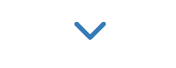

When you click the button Javascript makes a requests to an endpoint to get 30 more films. The response is not JSON but plain HTML that is later added to the current HTML section.
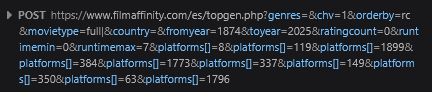

We can see that film are displayed inside an `ul` element and each film is an `li` element. Also, there is an special `li` with class="full-row" that seems like a delimiter each 10 films.

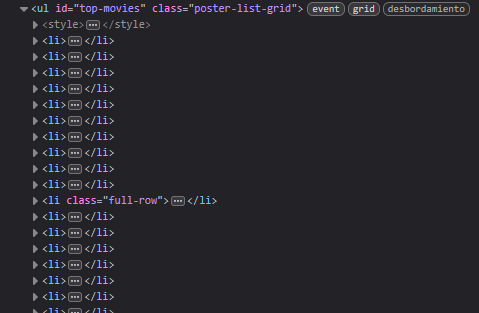

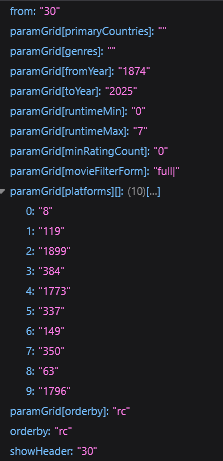

## Program

In [ ]:
# First I make a request to the Top FA section

top_fa_request = requests.get(BASE_URL + "/topgen.php")

In [13]:
# I'll need to find how to iterate trough all of the films

top_fa_request = BeautifulSoup(top_fa_request.text)


In [14]:
# We get the ul element for the movies

list_top_fa = top_fa_request.find(id="top-movies")

list_top_fa


<ul id="top-movies">
<li>
<ul>
<li class="position">1</li>
<li class="content">
<div class="movie-card mc-flex movie-card-0" data-movie-id="809297">
<div class="mc-poster">
<a href="https://www.filmaffinity.com/es/film809297.html"><img alt="El padrino " class="lazyload" data-src="https://pics.filmaffinity.com/the_godfather-488102675-msmall.jpg" height="" src="https://pics.filmaffinity.com/the_godfather-488102675-msmall.jpg" width="100"/></a>
</div>
<div class="mc-info-container">
<div class="mc-title"><a href="https://www.filmaffinity.com/es/film809297.html" title="El padrino">El padrino</a></div>
<div class="d-flex">
<img alt="Estados Unidos" class="nflag" src="/imgs/countries2/US.png"/><span class="mc-year">1972</span>
</div>
<div class="mc-director"><div class="credits"><span class="nb"><a href="https://www.filmaffinity.com/es/name.php?name-id=845159519" title="Francis Ford Coppola">Francis Ford Coppola</a></span></div></div>
<div class="mc-cast"><div class="credits"><span class="nb

From the hole list, we only need the link to the film. Therefore, we will save the links soo then we can request all the links in order to get the full information about each film.
As we only need the https://.../filmID.html we will get all the links, then we will apply a regex and finally deleting duplicates.

In [ ]:
a_elements = list_top_fa.find_all('a')

link_list = [link.get('href') for link in a_elements]

film_links = []

for link in link_list:
    if re.findall("https://.*/film[0-9]*.html", link):
        film_links.append(link)

film_links = set(film_links)
display(film_links)
display(len(film_links))


{'https://www.filmaffinity.com/es/film107937.html',
 'https://www.filmaffinity.com/es/film155010.html',
 'https://www.filmaffinity.com/es/film160882.html',
 'https://www.filmaffinity.com/es/film161026.html',
 'https://www.filmaffinity.com/es/film209631.html',
 'https://www.filmaffinity.com/es/film221477.html',
 'https://www.filmaffinity.com/es/film356260.html',
 'https://www.filmaffinity.com/es/film372160.html',
 'https://www.filmaffinity.com/es/film385464.html',
 'https://www.filmaffinity.com/es/film399474.html',
 'https://www.filmaffinity.com/es/film402150.html',
 'https://www.filmaffinity.com/es/film489970.html',
 'https://www.filmaffinity.com/es/film518489.html',
 'https://www.filmaffinity.com/es/film536488.html',
 'https://www.filmaffinity.com/es/film594480.html',
 'https://www.filmaffinity.com/es/film601451.html',
 'https://www.filmaffinity.com/es/film640188.html',
 'https://www.filmaffinity.com/es/film656153.html',
 'https://www.filmaffinity.com/es/film661074.html',
 'https://ww

30

Now that we have the first 30 films, we need to iterate in blocks of 30 from the number 30